In [1]:
import importlib
from copy import deepcopy
from Udep2Mono.util import btree2list
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline

2020-12-27 21:17:49 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | gum       |
| pos       | gum       |
| lemma     | gum       |
| depparse  | gum       |
| sentiment | sstplus   |
| ner       | ontonotes |

2020-12-27 21:17:49 INFO: Use device: gpu
2020-12-27 21:17:49 INFO: Loading: tokenize
2020-12-27 21:17:53 INFO: Loading: pos
2020-12-27 21:17:55 INFO: Loading: lemma
2020-12-27 21:17:55 INFO: Loading: depparse
2020-12-27 21:17:57 INFO: Loading: sentiment
2020-12-27 21:17:59 INFO: Loading: ner
2020-12-27 21:18:01 INFO: Done loading processors!


In [2]:
sentence = "a brown dog is attacking another animal in front of the tall man in pants"
pipeline = PolarizationPipeline(verbose=2)
annotation = pipeline.single_polarization(sentence)
#print(annotation['annotated'])
#print(annotation['word_dict'])
#print(annotation['polarized_tree'].sorted_leaves())


[['det', 1, 3], ['amod', 2, 3], ['nsubj', 3, 5], ['aux', 4, 5], ['root', 5, 'root'], ['det', 6, 7], ['obj', 7, 5], ['case', 8, 9], ['obl', 9, 5], ['case', 10, 13], ['det', 11, 13], ['amod', 12, 13], ['nmod', 13, 9], ['case', 14, 15], ['nmod', 15, 13]]

{'a': (1, 'DT'), 'brown': (2, 'JJ'), 'dog': (3, 'NN'), 'is': (4, 'VBZ'), 'attacking': (5, 'VBG'), 'another': (6, 'DT'), 'animal': (7, 'NN'), 'in': (14, 'IN'), 'front': (9, 'NN'), 'of': (10, 'IN'), 'the': (11, 'DT'), 'tall': (12, 'JJ'), 'man': (13, 'NN'), 'pants': (15, 'NNS')}
[nsubj  ['det'  ['DT'  'a']  ['amod'  ['JJ'  'brown']  ['NN'  'dog']]]  ['aux'  ['VBZ'  'is']  ['obj'  ['det'  ['DT'  'another']  ['NN'  'animal']]  ['obl'  ['case'  ['IN'  'in']  ['nmod'  ['case'  ['IN'  'of']  ['nmod'  ['case'  ['IN'  'in']  ['NNS'  'pants']]  ['det'  ['DT'  'the']  ['amod'  ['JJ'  'tall']  ['NN'  'man']]]]]  ['NN'  'front']]]  ['VBG'  'attacking']]]]]
[nsubj↑  ['det↑'  ['DT'  'a↑']  ['amod↑'  ['JJ'  'brown↑']  ['NN'  'dog↑']]]  ['aux↑'  ['VBZ'  

In [ ]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction

OPENIE_MODEL = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz"
ie_extractor = Predictor.from_path(OPENIE_MODEL)

In [1]:
import os
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

In [3]:
from pattern.en import pluralize, singularize

def fix_info(desc):
    out = desc.replace("ARG0: ", "")
    out = out.replace("ARG1: ", "")
    out = out.replace("V: ", "")
    out = out.replace("[", "")
    out = out.replace("]", ",")
    out = out.split(",")
    out = list(map(lambda x: x.strip(), out))
    out = list(map(lambda x: x.split(" "), out))
    return out

# TODO: Verb Phrase Patterns
# 1.Intransitive: subject + VI
# 2.Linking: subject + VL + NP/AdjP
# 3.Transitive: subject + VT + NP
# 4.Ditransitive: subject + VD + NP(indirect) + NP(direct)
# 5.Complex Transitive: subject + VC + NP(direct) + NP/AdjP
# 6.Open clausal complement: VB + to/that VP
class PhrasalGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.kb = {}
        self.tree_log = []
        self.sent_log = []
        self.mod_at_left = [
            "advmod", "amod", "advmod:count", "acl:relcl", 
            "acl", "advcl", "xcomp", "ccomp", "appos"]
        self.mod_at_right = []
        
        '''
            "ccomp": self.generate_ccomp,
            "compound": self.generate_inherite,
            "compound:prt": self.generate_inherite,
            "cop": self.generate_inherite,
            
            "expl": self.generate_expl,
            "nmod": self.generate_nmod,
            "nmod:npmod": self.generate_nmod,
            "nmod:tmod": self.generate_nmod,
            "nmod:poss": self.generate_nmod_poss,
            
            "nummod": self.generate_nummod,
            "obl": self.generate_obj,
            "obl:npmod": self.generate_oblnpmod,
            "obl:tmod": self.generate_inherite,
        '''

    def deptree_generate(self, tree, annotated, original):
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree
        self.annotated = annotated
        self.ie_pred = {}
        verbs = ie_extractor.predict(original)['verbs']
        for verb in verbs:
            self.ie_pred[verb['verb']] = fix_info(verb['description'])        
        self.generate(self.deptree)

    def generate(self, tree):
        if tree.val in self.mod_at_left:
            self.left_modifier_generate(tree)
        elif tree.val == "conj" and tree.mark == "+":
            self.generate_conj(tree)
        elif tree.left != "N":
            self.generate_default(tree)

    def delete_left_modifier(self, tree):
        tree.val = tree.right.val
        tree.mark = tree.right.mark
        tree.npos = tree.right.npos
        tree.id = tree.right.id
        tree.left = tree.right.left
        tree.right = tree.right.right

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.npos = backup.npos
        tree.id = backup.id

    def left_modifier_generate(self, tree):
        # adv + VB | VB + adv => VB
        # amod + Noun => Noun
        # Noun + relcl => Noun
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        if right.mark == "+":
            self.delete_left_modifier(tree)
            self.save_tree(isTree=True)
            self.rollback(tree, backup)   

        self.generate(tree.left)
        self.generate(tree.right) 

    def rollback_annotation(self, generated, original):
        word_id = self.annotated[generated]
        del self.annotated[generated]
        self.annotated[original] = word_id

    def generate_conj(self, tree):
        backup = deepcopy(tree)
        self.left_modifier_generate(tree)

        tree.val = tree.left.right.val
        tree.mark = tree.left.right.mark
        tree.npos = tree.left.right.npos
        tree.id = tree.left.right.id
        tree.left = backup.left.right.left
        tree.right = backup.left.right.right
        self.save_tree(isTree=True)
        self.rollback(tree, backup)

    def add_modifier(self, tree, mod, head, direct=0):
        if direct == 0:
            generated = ' '. join([mod, head])
        else:
            generated = ' '. join([head, mod])
        word_id = self.annotated[head]
        del self.annotated[head]
        self.annotated[generated] = word_id
        self.save_tree(isTree=False)
        self.rollback_annotation(generated, head)

    def generate_default(self, tree):
        left = tree.left
        right = tree.right

        if right.npos is not None:
            if "NN" in right.npos and right.mark == "-":
                for adj in kb["ADJ"]:
                    self.add_modifier(tree, adj, right.val)
                for rel in kb["RCL"]:
                    self.add_modifier(tree, rel, right.val, 1)
            elif "VB" in right.npos and right.mark == "-":
                for adv in kb["ADV"]:
                    self.add_modifier(tree, adv, right.val)
                    description = self.ie_pred[right.val]
                    arg1 = description[2][-1]
                    self.add_modifier(tree, adv, arg1, 1)

        self.generate(left)
        self.generate(right)  

    def save_tree(self, isTree):
        if isTree:
            self.tree_log.append(deepcopy(self.deptree))
        else:
            self.sent_log.append(deepcopy(self.annotated))
        
    def buildTree(self, config):
        left = BinaryDependencyTree(
            config['mod'], "N", "N", 1024, 
            wid=config['lid'], npos="JJ")
        right = BinaryDependencyTree(
            config['head'], "N", "N", 1024,
            wid=config['rid'], npos="NN")
        tree = BinaryDependencyTree(config['rel'], left, right, 1025)
        left.mark = config['mark']
        right.mark = config['mark']
        tree.mark = config['mark']
        return tree

100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

Polarization Complete


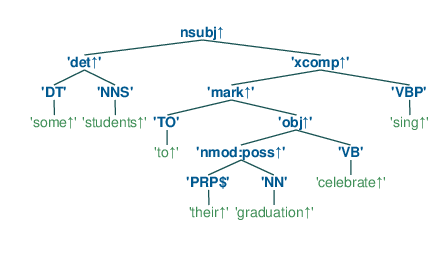

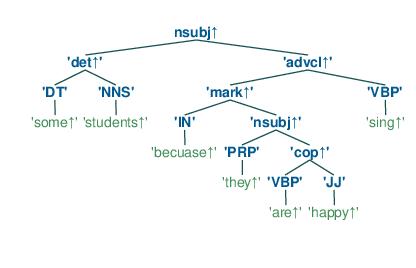

In [4]:
sentences = ["Some red flowers need light", 
             "Some red and beautiful flowers need light",
             "All flowers need light and water", 
             "No flowers need bright or warm light",
             "John can sing and dance",
             "John ate an apple and finished his homework",
             "John finished his homework and did not eat an apple"]

sentences2 = ["Some students sing to celebrate their graduation",
              "Some students sing becuase they are happy "]

kb = {"ADJ": ["beautiful", "red", "fragret"], 
      "ADV": ["ergently", "clearly", "neccesaraly"],
      "RCL": ["which is beautiful", "which opens at night"]}

pipeline = PolarizationPipeline(sentences2, verbose=0, parser="stanza")
pipeline.run_polarize_pipeline()
print("\nPolarization Complete")

with open("./generation_log.txt", 'w') as generate_log:
    phrasalGenerator = PhrasalGenerator()
    for annotation in pipeline.annotations:
        generate_log.write("\n====================================")
        generate_log.write("\nInit Premise: " + annotation['annotated'])
        polarized = annotation['polarized']
        btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
        jupyter_draw_nltk_tree(btreeViz) 
        phrasalGenerator.kb = kb
        phrasalGenerator.deptree_generate(
            annotation['polarized_tree'], annotation['word_dict'], annotation['original'])
        for gen_tree in phrasalGenerator.tree_log:
            generated, queue, _, _ = btreeToList(gen_tree, len(annotation['original']), {}, 0)
            annotated = list(queue.popkeys())
            generate_log.write("\nNext Premise: " + ' '.join(annotated))
        for gen_sent in phrasalGenerator.sent_log:
            generate_log.write("\nNext Premise: " + ' '.join(gen_sent.popkeys()))
    

In [3]:
import fasttext
from sapphire import Sapphire
model = fasttext.FastText.load_model(path_to_your_model)
aligner = Sapphire(model)
aligner.set_params(lambda_=0.6, delta=0.6, alpha=0.01, hungarian=False)

ImportError: cannot import name 'Sapphire' from 'sapphire' (unknown location)